In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import os
import matplotlib.pyplot as plt
from main import Generator3D, generate_noise, upsample_3d

output_dir = "Output_demo_76x88x144_dummy"
device = torch.device(f"cuda:0")
model_path = os.path.join(output_dir, 'trained_model_3d.pth')

saved_data = torch.load(model_path, map_location=device)
trained_generators_state_dicts = saved_data['generators_state_dicts']
fixed_noise_maps = saved_data['fixed_noise_maps']
pyramid_shapes = saved_data['pyramid_shapes']
train_opt_dict = saved_data['opt']
pyramid = saved_data['pyramid']

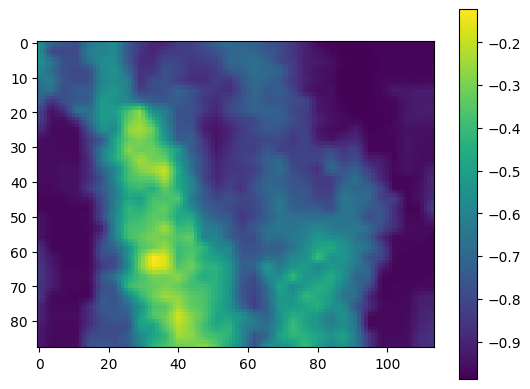

In [149]:
training_data = pyramid[10].detach().cpu().numpy()
training_data.shape
plt.imshow(training_data.squeeze().mean(0))
plt.colorbar()

In [5]:
# Create dummy pyramid for shape info if needed, or use saved shapes
# This part might need refinement depending on how gen_size interacts
class DummyOpt: pass
train_opt = DummyOpt()
for k, v in train_opt_dict.items(): 
    setattr(train_opt, k, v)
train_opt.nc_im = 1 # Assume single channel if not saved explicitly


In [197]:
def generate_3d_sample(trained_generators_state_dicts, 
                       pyramid, 
                       opt, device, 
                       gen_start_scale=0, 
                       custom_noise_shape=None):
    num_scales = len(trained_generators_state_dicts)
    generators = []
    # Load generators from state dicts
    for i in range(num_scales):
        netG = Generator3D(opt).to(device)
        # Load state dict corresponding to scale i (0=finest, N=coarsest)
        # Note: trained_generators was returned finest-to-coarsest
        netG.load_state_dict(trained_generators_state_dicts[i])
        netG.eval() # Set to evaluation mode
        generators.append(netG)

    # Determine starting scale index (N = num_scales - 1)
    start_scale_idx_actual = num_scales - 1 - gen_start_scale

    # Generate initial noise at the starting scale
    if custom_noise_shape:
        # Use custom shape (C, D, H, W)
        noise_shape = (opt.nc_im,) + tuple(custom_noise_shape)
    else:
        # Use shape from the corresponding pyramid level
        noise_shape = pyramid[num_scales - 1 - start_scale_idx_actual].shape[1:] # Get C, D, H, W

    current_noise = generate_noise(noise_shape, device)
    current_vol = torch.zeros((1,) + noise_shape, device=device) # Initial previous output is zero
    current_vol = pyramid[num_scales - 1 - start_scale_idx_actual]
    
    scale_factor_r = opt.scale_factor

    # Generate through the pyramid from start_scale down to 0 (finest)
    with torch.no_grad():
        for scale_idx in range(start_scale_idx_actual, -1, -1): # Iterate N, N-1,..., start_scale,..., 0
            # Get the generator for this scale (index maps directly: 0=finest, N=coarsest)
            # Need to map scale_idx (N..0) to list index (0..N)
            generator_list_idx = num_scales - 1 - scale_idx
            netG = generators[generator_list_idx]

            # Upsample previous volume
            prev_vol_upsampled = upsample_3d(current_vol, scale_factor=scale_factor_r)

            # Determine target size for this scale
            if custom_noise_shape and scale_idx == start_scale_idx_actual:
                 target_size = noise_shape[-3:]
            elif scale_idx < num_scales -1 : # Not the coarsest scale being generated
                 # Infer target size by scaling up from the next coarser scale's pyramid shape
                 coarser_pyramid_idx = num_scales - 1 - (scale_idx + 1)
                 coarser_dims = np.array(pyramid[coarser_pyramid_idx].shape[-3:])
                 target_dims_float = coarser_dims * scale_factor_r
                 target_size = tuple(np.round(target_dims_float).astype(int))
                 # Ensure minimum size 1
                 target_size = tuple(max(1, d) for d in target_size)
            else: # Coarsest scale being generated (scale_idx == num_scales - 1)
                 target_size = noise_shape[-3:] # Use noise shape directly


            # Resize upsampled volume and noise to target size
            prev_vol_upsampled = F.interpolate(prev_vol_upsampled, size=target_size, mode='trilinear', align_corners=False)
            pyramid_upsampled = F.interpolate(pyramid[coarser_pyramid_idx+1], size=target_size, mode='trilinear', align_corners=False) 
            # prev_vol_upsampled = (prev_vol_upsampled + pyramid_upsampled)/2
            noise_this_scale = F.interpolate(current_noise, size=target_size, mode='trilinear', align_corners=False)
            noise_this_scale = generate_noise(noise_this_scale.shape[1:], device)
            
            # Generate volume for this scale
            current_vol = netG(noise_this_scale, prev_vol_upsampled)

            # Prepare noise for the next finer scale (if any)
            if scale_idx > 0:
                # print(f"Generating noise for scale {scale_idx-1}")
                # print(f'target size: {target_size}')
                target_size = (1, *target_size)
                current_noise = generate_noise(target_size, device) # Generate new noise based on current size

    return current_vol

In [ ]:
REAL_1 = [] 
for i in range(10):
    REAL_1.append(generate_3d_sample(trained_generators_state_dicts,
                                pyramid, # Pass dummy pyramid for shape reference
                                train_opt, # Use options from training
                                device,
                                gen_start_scale=1).detach().cpu().numpy())


In [199]:
REAL_1 = np.array(REAL_1).squeeze()

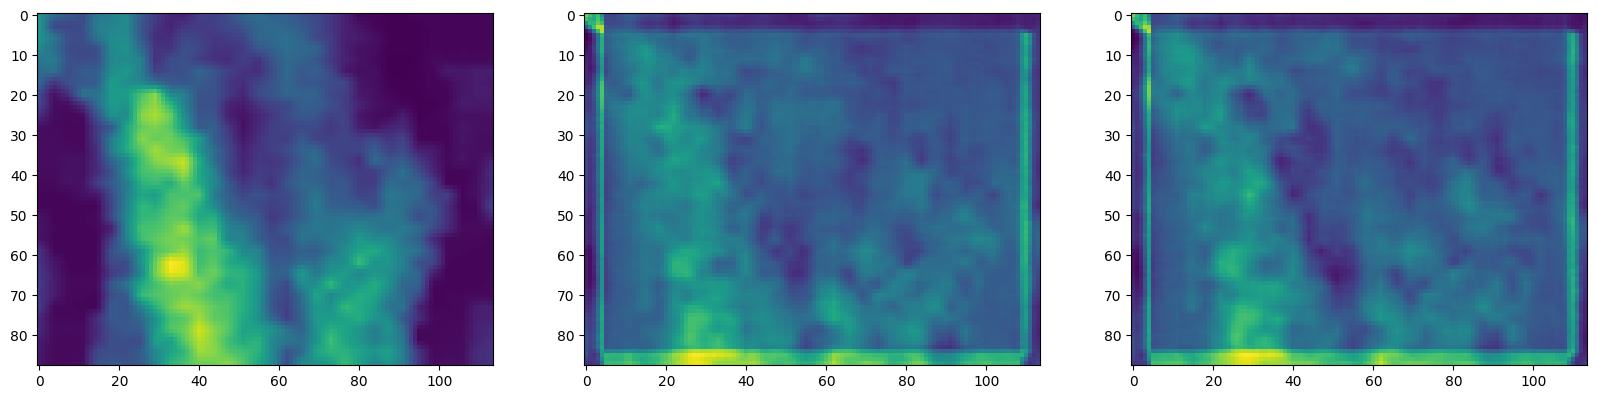

In [201]:
plt.figure(figsize = (20,10))
plt.subplot(1,3,1)
plt.imshow(training_data.squeeze().mean(0))
plt.subplot(1,3,2)
plt.imshow(REAL_1[0].mean(0)[:-1]-training_data.squeeze().mean(0)[:,:])
plt.subplot(1,3,3)
plt.imshow(REAL_1[1].mean(0)[:-1]-training_data.squeeze().mean(0)[:,:])